# CVAE-LSTM using information from the hidden states of the nHMM

In [3]:
import os
#os.environ["R_HOME"] = r"/Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources"  # Change this path according to your R installation.
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

In [4]:
covid_data = pd.read_excel('../data/raw/covid_data.xlsx',engine='openpyxl')

In [5]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Inmigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [6]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

In [7]:
reference_date = covid_data['Date'].min()  # Earliest date in your dataset

In [8]:
covid_data['Days'] = reference_date + pd.to_timedelta(covid_data['Days'], unit='D')

In [9]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


## Fitting the nHMM model with 6 hidden states and direct simulations with the obtained model

converged at iteration 80 with logLik: -17904.16 


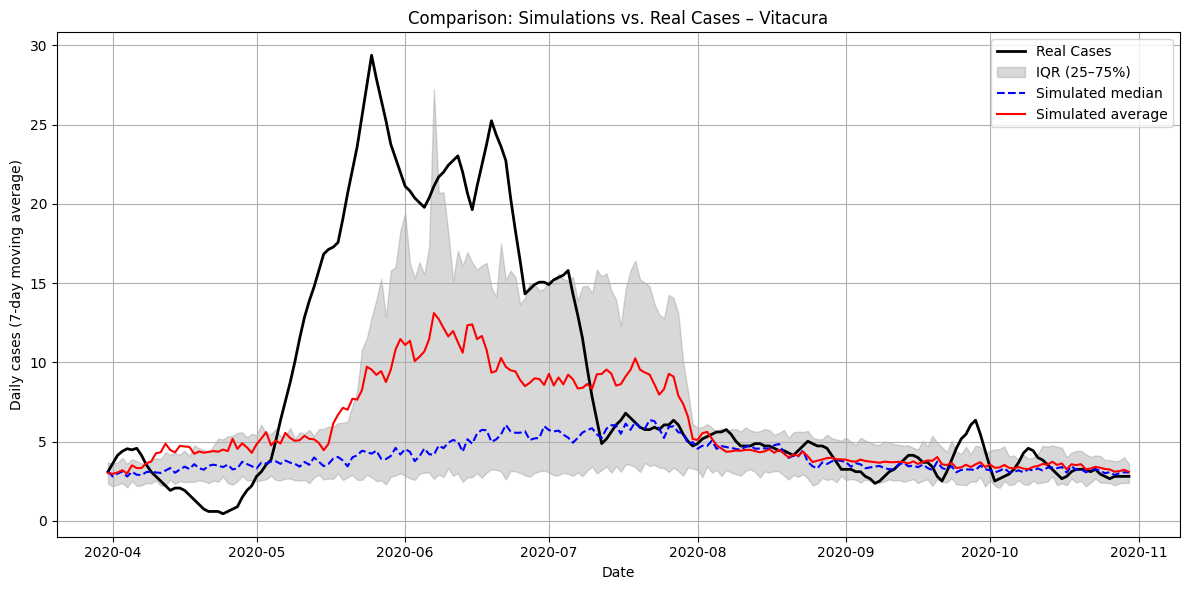

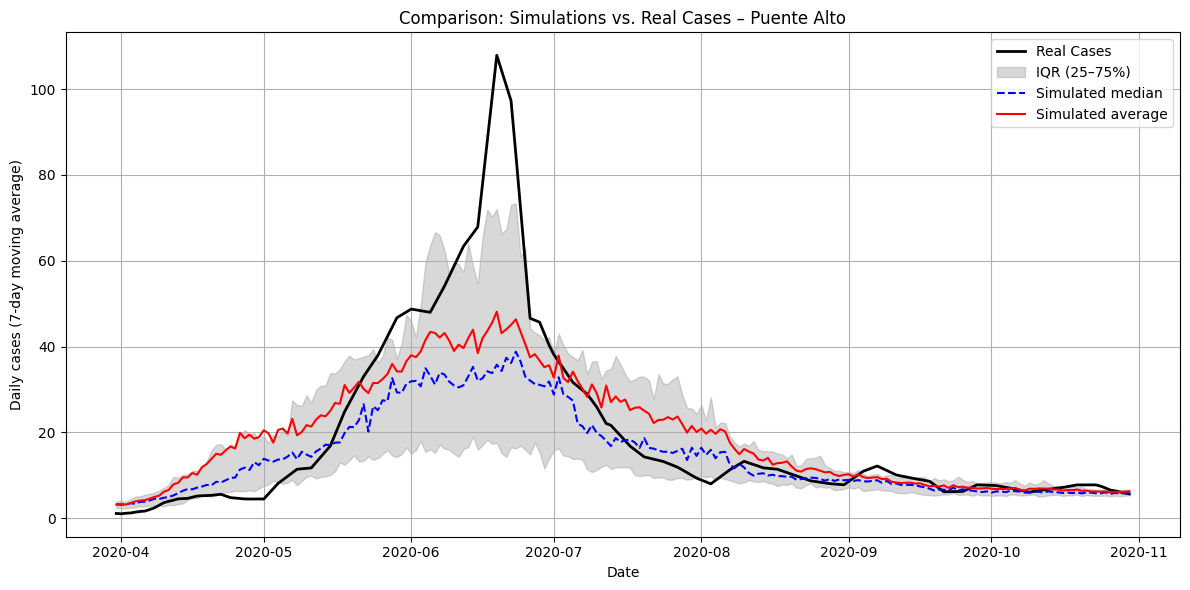

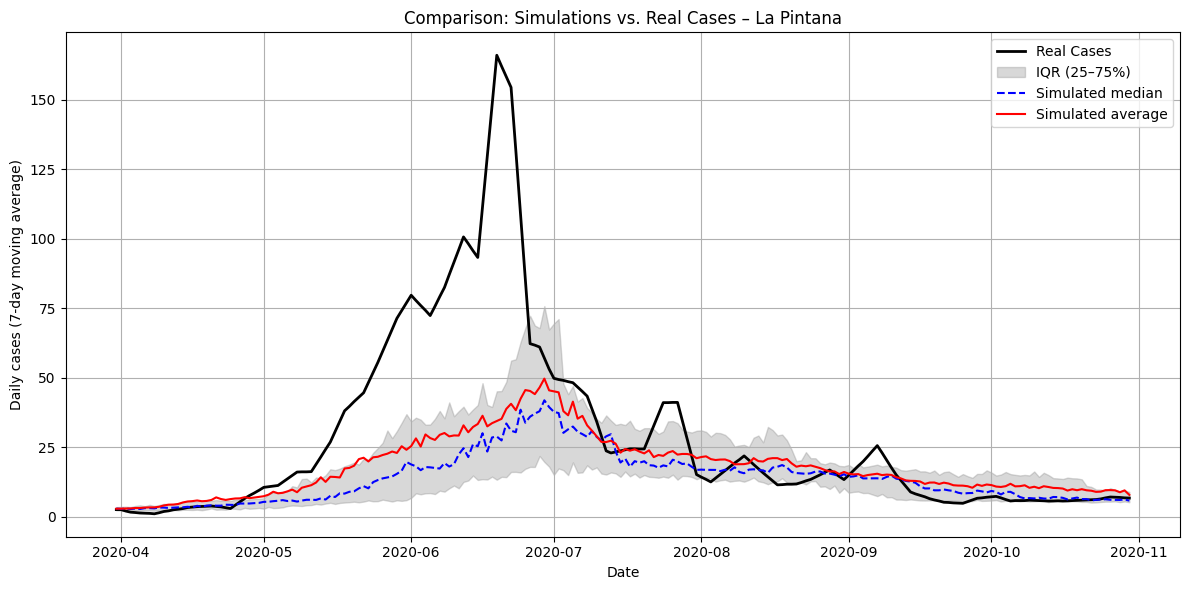

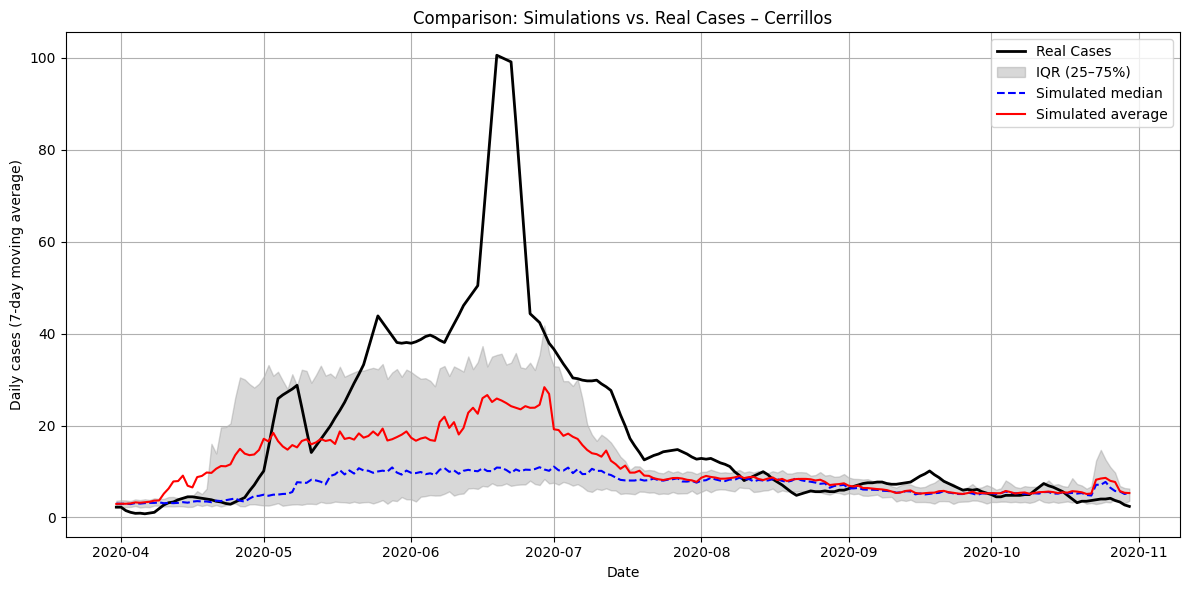

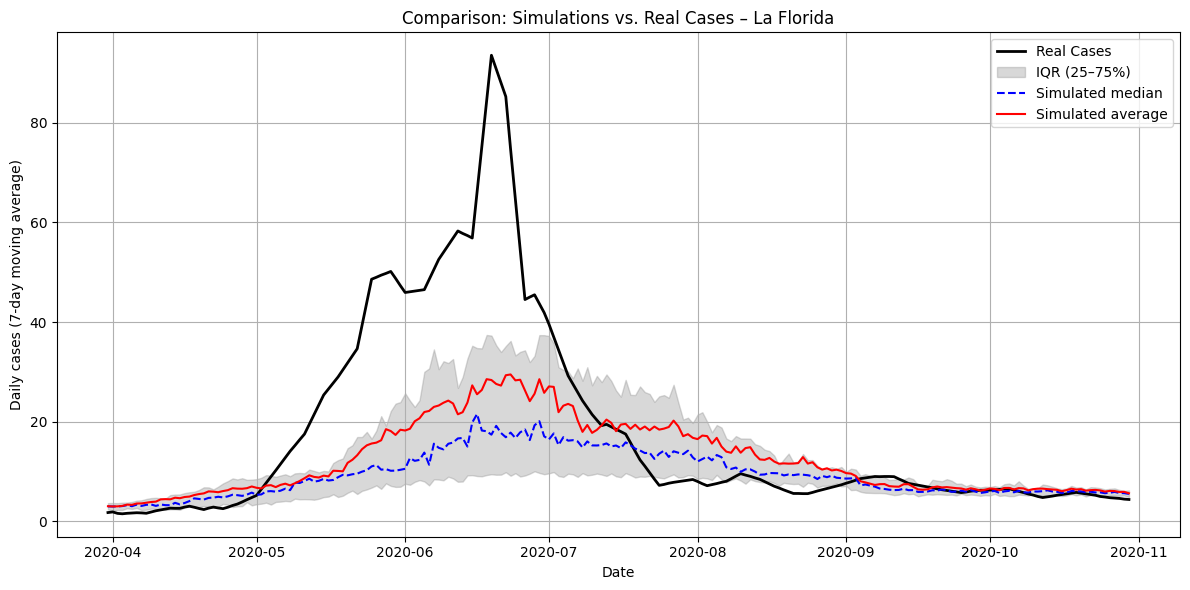

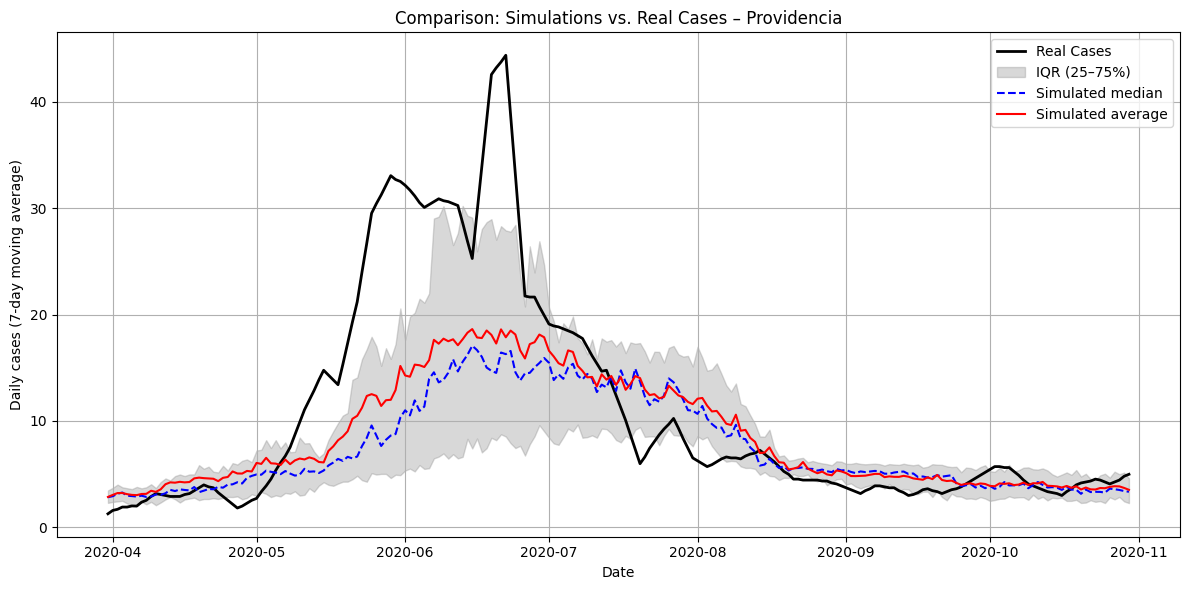

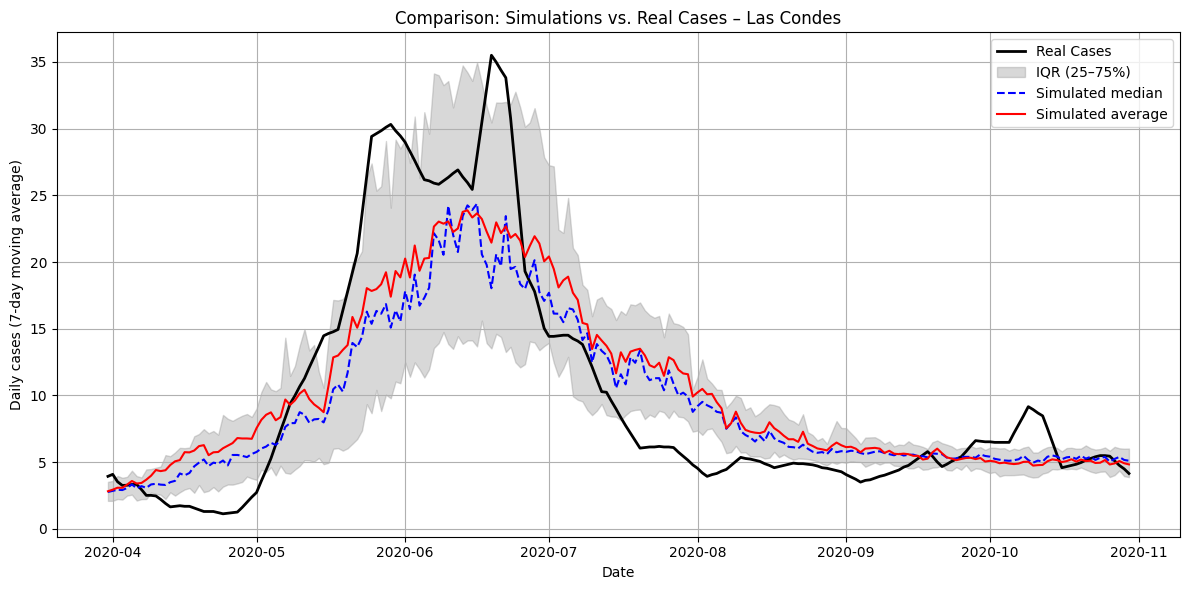

In [10]:
# Activate automatic conversion
pandas2ri.activate()
r.assign("covid_data_r", pandas2ri.py2rpy(covid_data))
r.assign("ntimes", pandas2ri.py2rpy(ntimes))

# Adjust HMM with formula in transformed scale
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")
gaussian_family = r["gaussian"]()
depmixS4 = importr("depmixS4")

hmm_model = depmixS4.depmix(
    response=hmm_formula,
    data=r["covid_data_r"],
    nstates=6,
    family=gaussian_family,
    transition=trans_formula,
    ntimes=r["ntimes"]
)
hmm_fitted = depmixS4.fit(hmm_model, verbose=False)
r.assign("hmm_fitted", hmm_fitted)
# Simulate 
N_sim = 100
r(f'''
set.seed(2030)
simulaciones_list <- vector("list", {N_sim})
for (i in 1:{N_sim}) {{
  sim <- simulate(hmm_fitted)
  sim_vals <- sim@response[[1]][[1]]@y
  simulaciones_list[[i]] <- sim_vals  # Inversa de Box-Cox
}}
sim_df <- as.data.frame(do.call(cbind, simulaciones_list))
colnames(sim_df) <- paste0("sim_", 1:{N_sim})
sim_df$Commune <- covid_data_r$Commune
sim_df$Date <- as.character(covid_data_r$Date)
''')

# Convert to pandas and fix dates
sim_df = pandas2ri.rpy2py(r['sim_df'])
sim_df['Date'] = pd.to_datetime(sim_df['Date'])

# Plot simulations vs. real data
target_communes = ["Vitacura", "Puente Alto", "La Pintana", "Cerrillos", "La Florida","Providencia", "Las Condes"]
for commune in target_communes:
    plt.figure(figsize=(12, 6))
    
    df_real = covid_data[covid_data["Commune"] == commune].sort_values("Date")
    plt.plot(df_real["Date"], df_real["Gross_Daily_Cases_Mobile_Average_7_Days"],
             label="Real Cases", linewidth=2, color="black")

    df_sim = sim_df[sim_df["Commune"] == commune].sort_values("Date")
    sim_cols = [col for col in df_sim.columns if col.startswith("sim_")]
    sim_values = df_sim[sim_cols].values
    dates = df_sim["Date"].values

    p25 = np.percentile(sim_values, 25, axis=1)
    p50 = np.percentile(sim_values, 50, axis=1)
    p75 = np.percentile(sim_values, 75, axis=1)
    mean = sim_values.mean(axis=1)

    plt.fill_between(dates, p25, p75, color="gray", alpha=0.3, label="IQR (25–75%)")
    plt.plot(dates, p50, linestyle="--", color="blue", label="Simulated median")
    plt.plot(dates, mean, linestyle="-", color="red", label="Simulated average")

    plt.title(f"Comparison: Simulations vs. Real Cases – {commune}")
    plt.xlabel("Date")
    plt.ylabel("Daily cases (7-day moving average)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [11]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

In [12]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head()) 

   state            S1            S2            S3        S4            S5  \
0    4.0  0.000000e+00  0.000000e+00  0.000000e+00  1.000000  0.000000e+00   
1    4.0  4.755913e-17  1.922385e-14  1.810559e-15  0.999991  4.943430e-19   
2    4.0  4.027281e-16  1.133234e-12  3.020021e-15  1.000000  3.884947e-18   
3    4.0  4.996985e-17  1.034203e-14  9.776392e-16  1.000000  2.831193e-19   
4    4.0  6.222329e-15  3.221134e-15  1.117261e-14  1.000000  7.530759e-17   

             S6  row_id  Internal_Mobility_Index  External_Mobility_Index  \
0  0.000000e+00       0                 1.970381                 7.804008   
1  8.601521e-06       1                 1.845790                 7.471452   
2  2.857901e-07       2                 1.678598                 6.891732   
3  7.337649e-08       3                 1.736766                 8.317872   
4  1.587943e-08       4                 1.331296                 6.378498   

   ...                Priority_2020   Code  Year  Month  Step  Step_

In [13]:
# Rename column 'state' to 'Hidden_State'.
viterbi_merged = viterbi_merged.rename(columns={"state": "Hidden_State"})

# Save as CSV in the specified location
output_path = '../data/processed/covid_data_with_6_states.csv'
viterbi_merged.to_csv(output_path, index=False)

print(f"File successfully saved in:\n{output_path}")


File successfully saved in:
../data/processed/covid_data_with_6_states.csv


## Construction of the CVAE-LSTM using information from the Viterbi sequence of the nHMM.

In [14]:
# =========================
# 1. CVAE-LSTM TRAINING
# =========================

# Local route
l = '../data/'
data_path = os.path.join(l, "processed/covid_data_with_6_states.csv")
model_path = os.path.join(l, "raw/cvae_lstm_model.pth")

# Load complete data
covid_data = pd.read_csv(data_path, parse_dates=["Date"])

# Ranking by severity and assigned weights
ranking = covid_data.groupby("Hidden_State")["Gross_Daily_Cases_Mobile_Average_7_Days"]\
                    .mean().sort_values(ascending=False)
weights_dict = {state: w for state, w in zip(ranking.index, [10, 6, 4, 2, 1, 1])}
covid_data["Severity_Weight"] = covid_data["Hidden_State"].map(weights_dict)

# Expand dataset according to severity of the condition
expanded = covid_data.loc[covid_data.index.repeat(covid_data["Severity_Weight"])].reset_index(drop=True)

# Features and conditions
features = ["Gross_Daily_Cases_Mobile_Average_7_Days", "Internal_Mobility_Index", "External_Mobility_Index"]
x_raw = expanded[features].values
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_raw)

enc_com = OneHotEncoder(sparse_output=False)
enc_st = OneHotEncoder(sparse_output=False)
cond_com = enc_com.fit_transform(expanded[["Commune"]])
cond_st = enc_st.fit_transform(expanded[["Hidden_State"]])
condition = np.concatenate([cond_com, cond_st], axis=1)

# Create sequences
def create_sequences(data, condition, seq_len=7):
    X, C, Y = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        C.append(condition[i+seq_len])
        Y.append(data[i+seq_len])
    return np.array(X), np.array(C), np.array(Y)

X_seq, C_seq, Y_seq = create_sequences(x_scaled, condition)

# Train/Test
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test, Y_train, Y_test = train_test_split(X_seq, C_seq, Y_seq, test_size=0.1)

# Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
C_train_t = torch.tensor(C_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_t, C_train_t, Y_train_t), batch_size=64, shuffle=True)

# Model
class CVAE_LSTM(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim, hidden_dim):
        super().__init__()
        self.lstm_enc = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim + cond_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim + cond_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )
    def encode(self, x, c):
        _, (h, _) = self.lstm_enc(x)
        h_cat = torch.cat([h[-1], c], dim=1)
        return self.fc_mu(h_cat), self.fc_logvar(h_cat)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)
    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

input_dim = X_seq.shape[2]
cond_dim = C_seq.shape[1]
latent_dim = 5
hidden_dim = 32

model = CVAE_LSTM(input_dim, cond_dim, latent_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def vae_loss(recon_x, x, mu, logvar):
    recon = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

# Training
model.train()
for epoch in range(50):
    total_loss = 0
    for x_batch, c_batch, y_batch in train_loader:
        optimizer.zero_grad()
        recon, mu, logvar = model(x_batch, c_batch)
        loss = vae_loss(recon, y_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

torch.save(model.state_dict(), model_path)


Epoch 1, Loss: 998.18
Epoch 2, Loss: 379.51
Epoch 3, Loss: 359.20
Epoch 4, Loss: 350.79
Epoch 5, Loss: 344.46
Epoch 6, Loss: 340.90
Epoch 7, Loss: 338.73
Epoch 8, Loss: 337.06
Epoch 9, Loss: 336.22
Epoch 10, Loss: 334.95
Epoch 11, Loss: 334.16
Epoch 12, Loss: 333.97
Epoch 13, Loss: 333.34
Epoch 14, Loss: 332.88
Epoch 15, Loss: 332.85
Epoch 16, Loss: 332.53
Epoch 17, Loss: 332.15
Epoch 18, Loss: 332.30
Epoch 19, Loss: 331.85
Epoch 20, Loss: 331.48
Epoch 21, Loss: 331.97
Epoch 22, Loss: 330.47
Epoch 23, Loss: 331.69
Epoch 24, Loss: 331.34
Epoch 25, Loss: 331.59
Epoch 26, Loss: 330.97
Epoch 27, Loss: 330.74
Epoch 28, Loss: 330.95
Epoch 29, Loss: 330.84
Epoch 30, Loss: 330.99
Epoch 31, Loss: 330.78
Epoch 32, Loss: 330.78
Epoch 33, Loss: 330.45
Epoch 34, Loss: 330.11
Epoch 35, Loss: 330.27
Epoch 36, Loss: 330.25
Epoch 37, Loss: 331.10
Epoch 38, Loss: 330.32
Epoch 39, Loss: 330.09
Epoch 40, Loss: 330.29
Epoch 41, Loss: 329.97
Epoch 42, Loss: 330.21
Epoch 43, Loss: 330.08
Epoch 44, Loss: 330.

## Simulations with CVAE-LSTM

✔️ Simulations saved in: ../data/processed/simulated_cases_from_cvae_lstm_weighted.csv


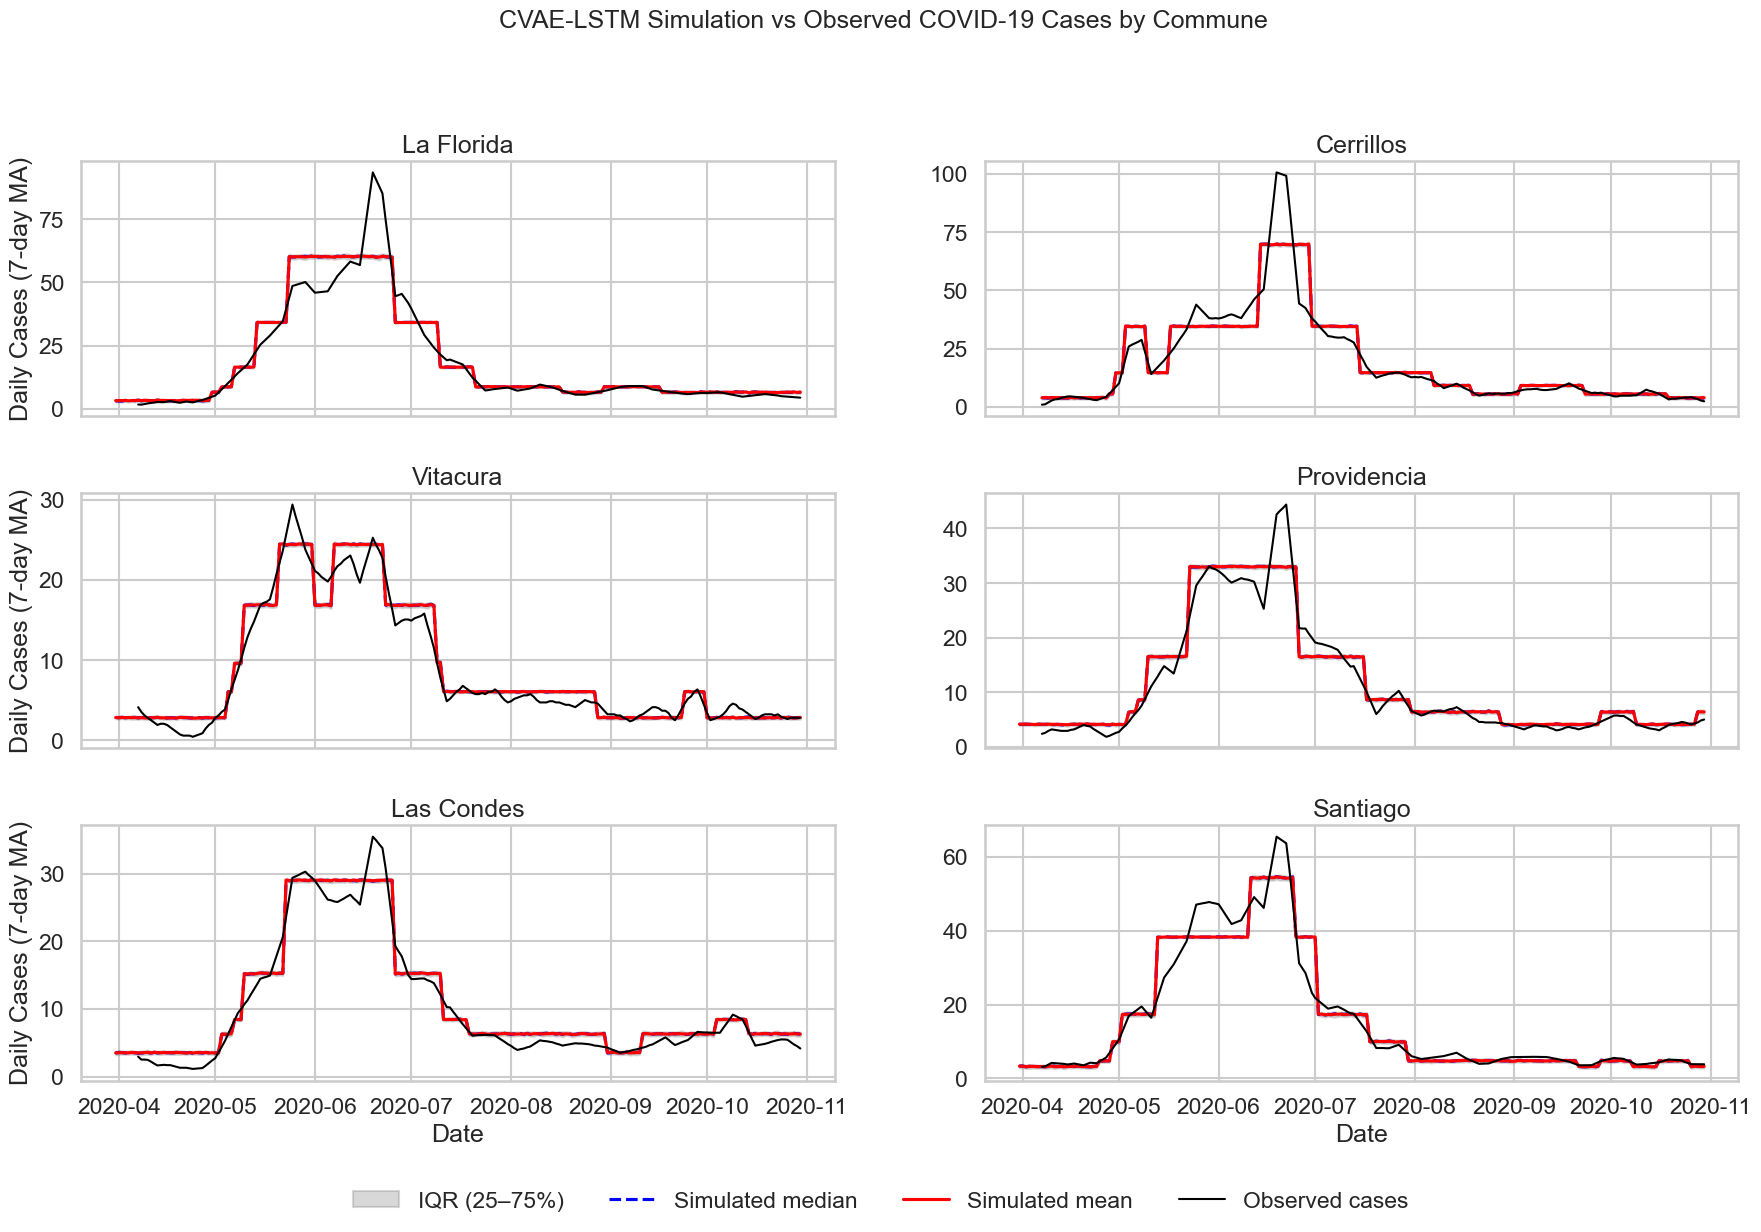

In [17]:
# =========================
# 2. SIMULATION + VISUALIZATION
# =========================
import seaborn as sns
import matplotlib.pyplot as plt

# Only the target communes
target_communes = ["La Florida", "Cerrillos", "Vitacura", "Providencia", "Las Condes", "Santiago"]
covid_data = pd.read_csv(data_path, parse_dates=["Date"])
covid_data = covid_data[covid_data["Commune"].isin(target_communes)]

x_raw = covid_data[features].values
x_scaled = scaler.transform(x_raw)

cond_com = enc_com.transform(covid_data[["Commune"]])
cond_st = enc_st.transform(covid_data[["Hidden_State"]])
condition = np.concatenate([cond_com, cond_st], axis=1)

X_seq, C_seq, _ = create_sequences(x_scaled, condition)

# Simulation
model.eval()
sim_results = []
with torch.no_grad():
    for _ in range(100):
        z = torch.randn(len(C_seq), latent_dim)
        cond_tensor = torch.tensor(C_seq, dtype=torch.float32)
        simulated = model.decode(z, cond_tensor).numpy()
        cases_sim = scaler.inverse_transform(simulated)[:, 0]
        sim_results.append(cases_sim)

# Create DataFrame
sim_df = pd.DataFrame(sim_results).T
sim_df.columns = [f"sim_{i+1}" for i in range(sim_df.shape[1])]
meta = covid_data.iloc[7:].reset_index(drop=True)[:sim_df.shape[0]]
sim_df["Date"] = meta["Date"]
sim_df["Commune"] = meta["Commune"]

# Save simulations
output_file = os.path.join(l, "processed/simulated_cases_from_cvae_lstm_weighted.csv")
sim_df.to_csv(output_file, index=False)
print(f"✔️ Simulations saved in: {output_file}")

# Visualization
sim_long = sim_df.melt(id_vars=["Date", "Commune"], var_name="Simulation", value_name="Sim_Cases")
real_df = covid_data.copy()

sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for idx, comuna in enumerate(target_communes):
    ax = axes[idx]
    sim_data = sim_long[sim_long["Commune"] == comuna]
    real_data = real_df[real_df["Commune"] == comuna].iloc[7:7+len(sim_data.groupby("Date"))]

    grouped = sim_data.groupby("Date")["Sim_Cases"]
    p25 = grouped.quantile(0.25)
    p75 = grouped.quantile(0.75)
    p50 = grouped.quantile(0.50)
    mean = grouped.mean()

    ax.fill_between(p25.index, p25, p75, color='gray', alpha=0.3, label="IQR (25–75%)")
    ax.plot(p50.index, p50, linestyle='--', color='blue', label='Simulated median')
    ax.plot(mean.index, mean, linestyle='-', color='red', label='Simulated mean')
    ax.plot(real_data["Date"].values,
            real_data["Gross_Daily_Cases_Mobile_Average_7_Days"].values,
            color='black', linewidth=1.5, label='Observed cases')
    ax.set_title(comuna)
    if idx % 2 == 0:
        ax.set_ylabel("Daily Cases (7-day MA)")
    if idx >= 4:
        ax.set_xlabel("Date")

fig.legend(*axes[0].get_legend_handles_labels(), loc='lower center', ncol=4, frameon=False)
fig.suptitle("CVAE-LSTM Simulation vs Observed COVID-19 Cases by Commune", fontsize=18, y=1.02)
fig.tight_layout(rect=[0, 0.05, 1, 0.98])
fig.subplots_adjust(hspace=0.3, wspace=0.2)
# Path to figures
f = '../results/figures/'

fig.savefig(os.path.join(f, "cvae_lstm_weighted_sim_vs_real.png"), dpi=600)
fig.savefig(os.path.join(f, "cvae_lstm_weighted_sim_vs_real.pdf"), dpi=600)
plt.show()


### Improving visualization

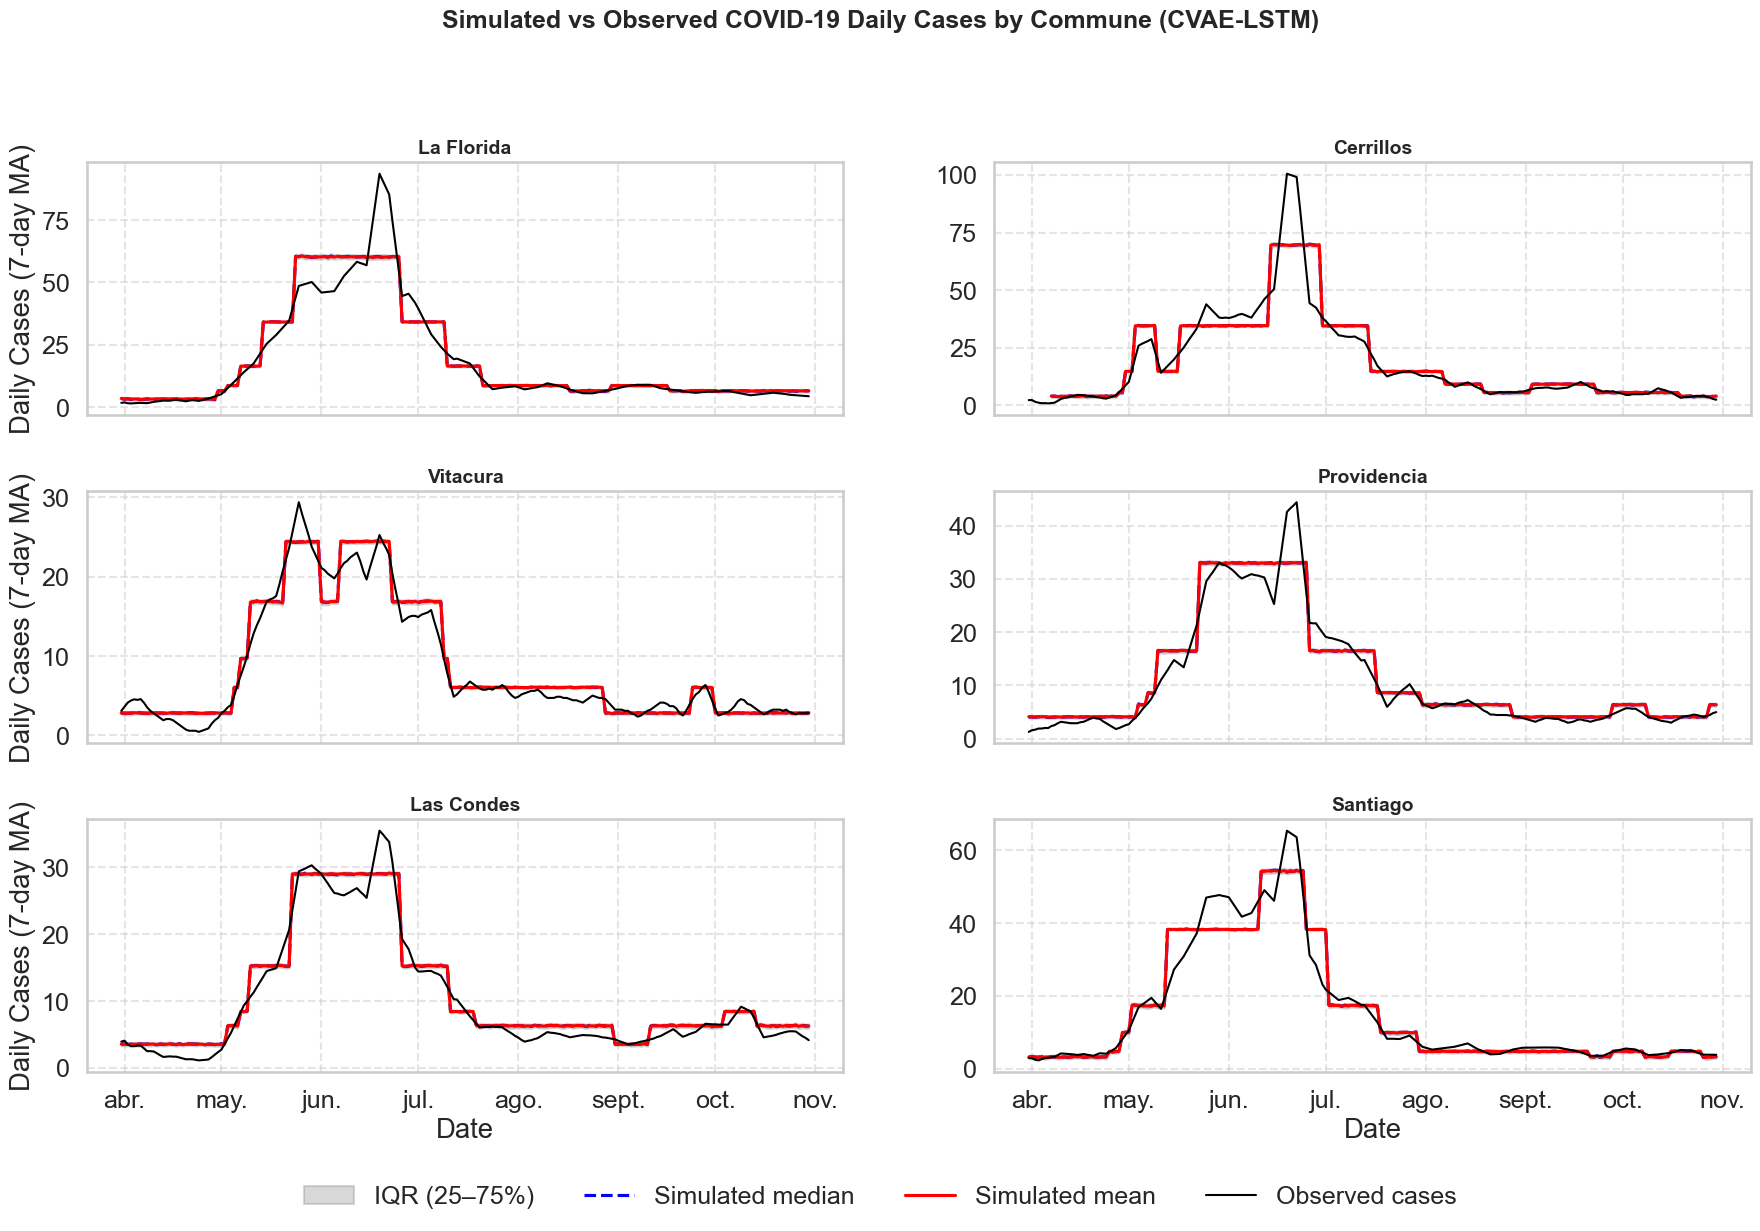

In [16]:
# =====================================
# CVAE-LSTM Simulation: Final Plot Code
# =====================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os

# Path to data
l = '../data/'
sim_path = os.path.join(l, "processed/simulated_cases_from_cvae_lstm_weighted.csv")
real_path = os.path.join(l, "processed/covid_data_with_6_states.csv")

# Load simulation and real data
sim_df = pd.read_csv(sim_path, parse_dates=["Date"])
real_df = pd.read_csv(real_path, parse_dates=["Date"])

# Target communes
target_communes = ["La Florida", "Cerrillos", "Vitacura", "Providencia", "Las Condes", "Santiago"]
sim_df = sim_df[sim_df["Commune"].isin(target_communes)]
real_df = real_df[real_df["Commune"].isin(target_communes)]

# Reshape simulation dataframe
sim_cols = [col for col in sim_df.columns if col.startswith("sim_") or col.startswith("X")]
sim_long = sim_df.melt(id_vars=["Date", "Commune"], value_vars=sim_cols,
                       var_name="Simulation", value_name="Sim_Cases")

# Plot aesthetics
sns.set(style="whitegrid", context="talk", font_scale=1.1)
fig, axes = plt.subplots(3, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for idx, commune in enumerate(target_communes):
    ax = axes[idx]
    sim_data = sim_long[sim_long["Commune"] == commune]
    real_data = real_df[real_df["Commune"] == commune].copy()

    grouped = sim_data.groupby("Date")["Sim_Cases"]
    p25 = grouped.quantile(0.25)
    p75 = grouped.quantile(0.75)
    p50 = grouped.quantile(0.50)
    mean = grouped.mean()

    # Plot uncertainty band
    ax.fill_between(p25.index, p25, p75, color='gray', alpha=0.3, label="IQR (25–75%)")

    # Simulated trajectories
    ax.plot(p50.index, p50, linestyle='--', color='blue', label='Simulated median')
    ax.plot(mean.index, mean, linestyle='-', color='red', label='Simulated mean')

    # Real data
    ax.plot(real_data["Date"], real_data["Gross_Daily_Cases_Mobile_Average_7_Days"],
            color='black', linewidth=1.5, label='Observed cases')

    # Labels and formatting
    ax.set_title(commune, fontsize=14, weight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)

    # X and Y axes
    if idx % 2 == 0:
        ax.set_ylabel("Daily Cases (7-day MA)")
    if idx >= 4:
        ax.set_xlabel("Date")

    # Format x-axis with month abbreviations
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False, fontsize=18)

fig.suptitle("Simulated vs Observed COVID-19 Daily Cases by Commune (CVAE-LSTM)", 
             fontsize=18, weight='bold', y=1.02)
fig.tight_layout(rect=[0, 0.05, 1, 0.98])
fig.subplots_adjust(hspace=0.3, wspace=0.2)

# Path to figures
f = '../results/figures/'

# Save output
fig.savefig(os.path.join(f, "cvae_lstm_simulated_vs_real_en.png"), dpi=600)
fig.savefig(os.path.join(f, "cvae_lstm_simulated_vs_real_en.pdf"), dpi=600)

plt.show()
